## Master Thesis - Predicting Remaining Useful Life with Bidirectional Long-Short Term Memory Network
Author: Goncalo Felicio
Date: 2021

This thesis was mostly developed using the kaggle notebooks given the ease of use and access to free GPUs for training at the time. Saving it here for record.

### Abstract


Asset failures are hard to foresee and can incur significant losses in the manufacturing industry. The present work explores the application of a Bidirectional Long Short Term Memory network to predict the Remaining Useful Life, in the context of predictive maintenance. A successful predictive maintenance strategy can not only reduce breakdowns and downtime of assets, but also maximize production, improve product quality, and safety of workers. Therefore, the aim of this work is to propose a framework with the goal of accurately predicting the Remaining Useful Life of assets from monitoring sensing data. The model is applied to the N-CMAPSS dataset, which contains full run-to-failure curves of turbofan engines, published by the Prognostics Center of Excellence at NASA Ames Research Center, in 2021. The proposed Bidirectional Long Short Term Memory model is compared against three benchmark models using Random Forest, Extreme Gradient Boosted Trees and Long-Short Term Memory Network. Simulation results with this novel dataset indicate that the implementation of the Bidirectional Long-Short Term Memory, with the proper fine tuning and feature selection, outperforms the other models, being a promising solution for providing critical information to support decision making for predictive maintenance strategies.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ds01asdasda/DS01Test10min.obj
/kaggle/input/ds01asdasda/DS01Train10min.obj


#### Imports

In [5]:
# import required libraries
import time
import math
import pickle
import xgboost
import seaborn as sns
from tqdm import tqdm
from pylab import rcParams

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0
import tensorflow as tf
tf.random.set_seed(2)

from tensorflow import keras
from keras import callbacks
import keras.backend as K
from keras.callbacks import History, EarlyStopping
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout, Activation, Bidirectional
from keras.models import Sequential, load_model

#### Data loading

In [6]:
# load the variable from the specific name
fp = open('../input/ds01asdasda/DS01Train10min.obj', 'rb')
train_df = pickle.load(fp)
    
tp = open('../input/ds01asdasda/DS01Test10min.obj', 'rb') 
test_df = pickle.load(tp)

#dp = open('../input/ds08c-10min/DS08cTest10min.obj', 'rb') 
#test_df = pickle.load(dp)

In [7]:
#testing purposes
#seq_array_train, label_array_train, lstm_test_df, sequence_length, sequence_cols = lstm_data_preprocessing(train_df, test_df)

In [8]:
#testing purposes dont run
#nb_features = seq_array_train.shape[2]
#print(nb_features)
#nb_out = label_array_train.shape[1]
#print(nb_out)

In [9]:
#train_df =train_df1.append(test_df1)

In [10]:
train_df.head*()

,unit,cycle,Fc,hs,alt,Mach,TRA,T2,T24,T30,...,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi,RUL
0,1.0,1.0,1.0,1.0,5884.085000,0.421574,71.484013,515.387075,610.709403,1452.927322,...,250.784219,29.132636,17.479581,237.301163,251.094185,16.581463,9.689020,25.811075,41.775968,99.0
1,1.0,1.0,1.0,1.0,10184.035000,0.502095,66.678626,506.740967,595.181466,1403.435373,...,215.397716,24.952605,14.971563,203.039496,214.886869,18.353363,8.839413,27.087167,40.110291,99.0
2,1.0,1.0,1.0,1.0,10486.290000,0.522611,58.994550,507.563580,588.587663,1372.402394,...,202.401900,23.417474,14.050485,190.366274,201.498359,19.367237,8.258969,28.297363,38.736141,99.0
3,1.0,1.0,1.0,1.0,10486.375000,0.522816,58.762375,507.583883,588.383792,1371.415710,...,202.031456,23.373716,14.024229,190.005270,201.117010,19.393137,8.243216,28.338397,38.691394,99.0
4,1.0,1.0,1.0,1.0,10484.706667,0.522765,58.918087,507.585010,588.537794,1372.104161,...,202.297673,23.405163,14.043098,190.264435,201.390819,19.377295,8.252526,28.311452,38.721427,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8178,6.0,94.0,2.0,0.0,11077.143333,0.464199,49.709998,499.817739,571.975543,1318.089185,...,176.153876,20.316927,12.190156,165.074388,174.762362,18.737657,7.081766,28.312915,38.070968,0.0
8179,6.0,94.0,2.0,0.0,11077.588333,0.464391,50.237191,499.832927,572.591772,1320.669590,...,177.113711,20.430307,12.258184,166.004307,175.745577,18.714799,7.112055,28.241524,38.172915,0.0
8180,6.0,94.0,2.0,0.0,10818.153333,0.412988,37.150810,496.543746,555.919851,1257.688568,...,154.674882,17.779720,10.667832,144.258300,152.765951,17.625276,6.919088,30.137930,35.665234,0.0
8181,6.0,94.0,2.0,0.0,7663.740000,0.371906,28.516790,504.940751,556.744707,1239.854212,...,154.973910,17.815043,10.689026,144.429886,152.953480,16.227217,6.786474,31.156117,34.395881,0.0


### Evaluation Metrics

In [ ]:
#Error Function for Competitive Data - From NASA's scoring function
def score(y_true,y_pred, a1=10, a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a1) - 1
        else:
            score += math.exp(-i/a2) - 1
    return score

# Adding the other scoring functions
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    
    print(f' NASA score {lst[0]}')
    print(f' Mean absolute error {lst[1]}')
    print(f' Root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [ lst[1], round(lst[2],2), lst[3]*100]

### Evaluation Graphs

In [ ]:
def lstm_val_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    #fig_acc = plt.figure(figsize=(10, 10))
    #plt.plot(history.history['r2_keras'])
    #plt.plot(history.history['val_r2_keras'])
    #plt.title('model r^2')
    #plt.ylabel('R^2')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'val'], loc='upper left')
    #plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    #print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred)
    test_set.head()

In [ ]:
def lstm_test_evaluation(lstm_test_df, model_LSTM, sequence_length, sequence_cols):
    
    # We pick the last sequence for each id in the test data
    seq_gen_test = (list(gen_sequence(lstm_test_df[lstm_test_df['unit']==id], sequence_length, sequence_cols)) 
               for id in lstm_test_df['unit'].unique())

    seq_array_test = np.concatenate(list(seq_gen_test)).astype(np.float32)
    print("\n seq_array_test shape >> ", seq_array_test.shape)
    
    # generate labels - Label used is RUL as we are predicting RUL
    label_gen_test = [gen_labels(lstm_test_df[lstm_test_df['unit']==id], sequence_length, ['RUL']) 
                 for id in lstm_test_df['unit'].unique()]
    label_array_test = np.concatenate(label_gen_test).astype(np.float32)
    print("\n label_array_test shape >> ",label_array_test.shape)
    
    estimator = model_LSTM

    # test metrics
    scores_test = estimator.evaluate(seq_array_test, label_array_test, verbose=1)
    print('\nMAE: {}'.format(scores_test[1]))
    #print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test)
    y_true_test = label_array_test
    
    # second opinion metrics
    print("\n Second Opinion metrics using the custom score function:")
    scores2nd =  score_func(y_true_test,y_pred_test)


    # Plot in blue color the predicted data and in green color the
    # ploting true and predicted data
    plot_result(y_true_test,y_pred_test)
    
    # fig_verify.savefig("model_regression_verify.png")
    return scores_test[1], scores2nd[2], seq_array_test, label_array_test, y_pred_test

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements]

### Dataset Pre processing

Find features that have missing values and features that have only constant values. The features with these characteristics are then removed from the dataset

In [32]:
def lstm_data_preprocessing(raw_res_train_data, raw_res_test_data): 
    
    # assigning the variables Train - Validation -  Test
    train_df = raw_res_train_data
    test_df = raw_res_test_data
    
    # TRAINING DATA - Processing and creating the Sequence and Label Arrays
    #################
    # drop unusable features
    train_df = train_df.drop(columns = ['hs'])
    # from Correlation Matrix - 14 feat
    # 'hs','Mach','TRA','Nf','Wf','P2','P40','Ps30','T48','Nc','T50','P50','P24','P21','phi','SmFan','P45','W22','W25','W31','W32','W48','W50'
    # from Importance analysis - 23 feat
    # 'hs','T30','T40','Ps30','T48','Nc','T50','phi','P45','Wf','P40','W31','P30'
    # all features - 36
    # 'hs','unit', 'cycle', 'Fc', 'alt', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf', 'T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi'
    
    # creating "label1" and "label2" columns for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within "label1" cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    # MinMax normalization of all features (from 0 to 1) 
    #train_df['cycle_norm'] = train_df['cycle']
    # Making these columns exceptions to normalization as they are not training features
    cols_normalize = train_df.columns.difference(['unit','cycle','RUL','label1','label2'])

    min_max_scaler = MinMaxScaler()

    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)
    # joining normalized features with non-normalized columns
    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)
    train_df = train_df.reset_index(drop=True)
    
    
    # Visualizing Training data    
    print("train_df shape >> ", train_df.shape)
    print("train_df >> ",train_df.head())
    print("\n")

    # TEST DATA
    #################
    # first part is same as done with training data
    # drop unusable features
    test_df = test_df.drop(columns = ['hs'])
    
    #test_df['cycle_norm'] = test_df['cycle']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)
    
    # Switching 'RUL' column with 'cycle_norm' column to 
    # get a list of the columns
    cols = list(test_df.columns)
    # use this handy way to swap the elements
    #a, b = cols.index('RUL'), cols.index('cycle_norm')
    #cols[b], cols[a] = cols[a], cols[b]
    #test_df = test_df[cols]
    
    # generate label columns w0 and w1
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
    
    # Visualizing Validation data
    print("test_df shape >> ", test_df.shape)
    print("test_df >> ", test_df.head())

    # GENERATING THE SEQUENCES
    #################
    ## pick a large window size of X steps; for sampling size of 1 min, 500 sequence length gives a total of 500 min of window size
    sequence_length = 50
            
    # pick the feature columns - as we switched 'RUL' column with 'cycle_norm', last 3 columns
    # are target labels 
    sequence_cols = list(test_df.columns[:-3])
    print(sequence_cols)
    
    # visualizing sequence generation
    val=list(gen_sequence(train_df[train_df['unit']==1], sequence_length, sequence_cols))
    print(len(val))

    # generator for the sequences for features and for label
    # transform each id of the train dataset in a sequence
    seq_gen_train = (list(gen_sequence(train_df[train_df['unit']==id], sequence_length, sequence_cols)) 
               for id in train_df['unit'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen_train)).astype(np.float32)
    print("\nseq_array_train shape >> ", seq_array.shape)


    # generate labels - Label used is RUL as this time we are predicting RUL
    label_gen_train = [gen_labels(train_df[train_df['unit']==id], sequence_length, ['RUL']) 
                 for id in train_df['unit'].unique()]

    label_array = np.concatenate(label_gen_train).astype(np.float32)
    print("\nlabel_array_train shape >> ",label_array.shape)
    print(label_array)
    
    return seq_array, label_array, test_df, sequence_length, sequence_cols

### Proposed ML Model Architecture

In [33]:
# Function for training all models: "Random forest", "XGBoost" and "LSTM"
# data must be resampled previously

def train_models(data,model = 'FOREST'):
    
    # Preparing train data for RF and XGB
    if model != 'BiLSTM' :
        # drop unusable features
        data_train = data.drop(columns = ['hs'])
        # Extract all features except the target RUL - 37 feat - 19 unusable feat - 1 RUL = 17 features
        X_train = data_train.iloc[:,:35].to_numpy()
        # Extract RUL
        y_train = data_train['RUL'].to_numpy()
        y_train = np.ravel(y_train)

    if model == 'FOREST':
         #  parameters for models are selected in a similar cycle, with the introduction 
         # of an additional param parameter into the function:
         #for i in range(1,11):
         #     xgb = train_models(train_df,param=i,model="XGB",)
         #     y_xgb_i_pred = xgb.predict(X_001_test)
         #     print(f'param = {i}')
         #     score_func(y_true,y_xgb_i_pred)
        model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        
        model.fit(X_train, y_train)
        return model
    
    elif model == 'XGB':
        model = xgboost.XGBRegressor(verbosity = 0)
        model.fit(X_train, y_train)
        return model
    
    elif model == 'BiLSTM':
        # Preparing the raw data the same as in RF and XGB but inside lstm_data_preprocessing function
        seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = lstm_data_preprocessing(data[0], data[1])
        # training Bidirectional LSTM model and Outputing full history and results for each epoch 
        model_instance, history = bilstm_train(seq_array, label_array, sequence_length)
        return model_instance, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols
            
    return

In [34]:
#function for joint display of real and predicted values

def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('Samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION of Real and Predicted values')
    plt.show()
    return

In [35]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_bilstm_model(sequence_length,
                        dropout=0.5,layer1_units=256,layer2_units=256,layer5_units=64, nb_features=35,nb_out=1):
    # The first layer is an Bi LSTM layer with 100 units followed by another BiLSTM layer with 100 units, and then the last hidden BiLSTM layer with 50 units 
    # Dropout is also applied after each LSTM layer to control overfitting. 
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    # for testing, did not improve result
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    
    model = Sequential()
    # Adding a Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=layer1_units, return_sequences=True),
        input_shape=(sequence_length, nb_features)))
    model.add(Dropout(dropout), )
    model.add(Bidirectional(LSTM(units=layer2_units, return_sequences=True)))
    model.add(Dropout(dropout), )
    #model.add(Bidirectional(LSTM(units=layer3_units, return_sequences=True)))
    #model.add(Dropout(dropout), )
    #model.add(Bidirectional(LSTM(units=layer4_units, return_sequences=True)))
    #model.add(Dropout(dropout), )
    model.add(Bidirectional(LSTM(units=layer5_units, return_sequences=False)))
    model.add(Dropout(dropout), )
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    
    print(model.summary())
    return model

def bilstm_train(seq_array, label_array, sequence_length):

    epochs = 1000
    batch_size = 512
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  
    model_bilstm = create_bilstm_model(sequence_length,)

    print(model_bilstm.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff 
    history = model_bilstm.fit(seq_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[es])
              #callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
              #             keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
              #)
    # list all data in history
    # print(history.history.keys())
    
    return model_bilstm, history

### Training and Results

#### Model BiLSTM 

train_df shape >>  (8183, 38)
train_df >>     unit  cycle   Fc       alt      Mach       TRA        T2       T24  \
0   1.0    1.0  0.0  0.088623  0.363451  0.762491  0.928488  0.887124   
1   1.0    1.0  0.0  0.223178  0.526238  0.685535  0.841135  0.771572   
2   1.0    1.0  0.0  0.232637  0.567713  0.562477  0.849446  0.722503   
3   1.0    1.0  0.0  0.232639  0.568127  0.558758  0.849651  0.720986   
4   1.0    1.0  0.0  0.232587  0.568024  0.561252  0.849662  0.722132   

        T30       T48  ...       W32       W48       W50     SmFan     SmLPC  \
0  0.872753  0.858967  ...  0.834272  0.833245  0.833282  0.281314  0.806557   
1  0.752797  0.732495  ...  0.665403  0.664006  0.664069  0.419537  0.659679   
2  0.677581  0.639540  ...  0.603385  0.601406  0.601498  0.498628  0.559333   
3  0.675189  0.636574  ...  0.601617  0.599622  0.599716  0.500648  0.556610   
4  0.676858  0.638597  ...  0.602888  0.600903  0.600996  0.499413  0.558219   

      SmHPC       phi   RUL  label1  

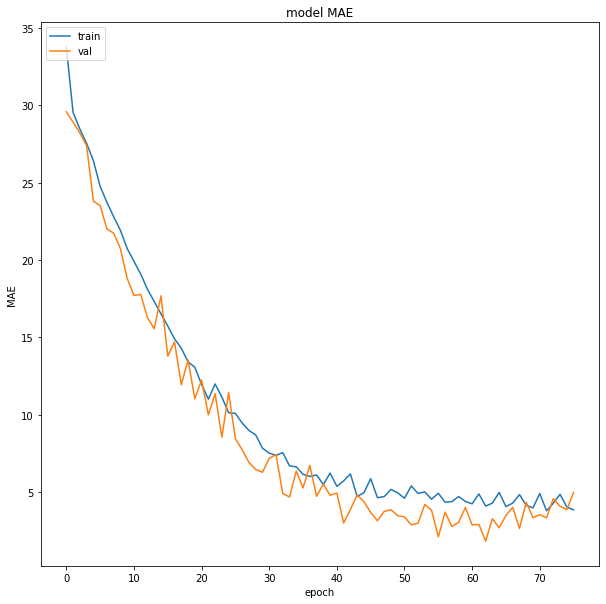

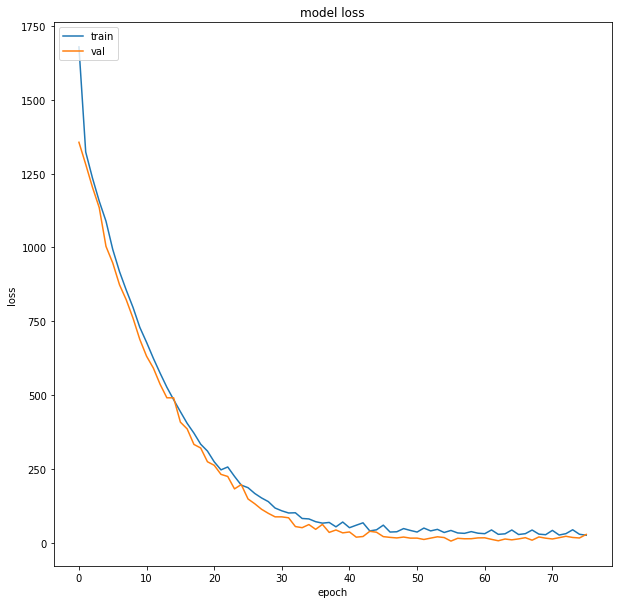

40/40 [==============================] - 1s 22ms/step - loss: 20.9618 - mae: 3.6864

MAE: 3.686378240585327
40/40 [==============================] - 2s 20ms/step
CPU times: user 1min 32s, sys: 5.97 s, total: 1min 38s
Wall time: 1min 59s


In [36]:
%%time
# function calling - input is resampled raw Training data 
model_BiLSTM, history, lstm_test_df, seq_array_train, label_array_train, sequence_length, sequence_cols = train_models([train_df, test_df], "BiLSTM")

## Training results graphs : comparing training data and validation data - 90/10 split

lstm_val_evaluation_graphs(model_BiLSTM, history, seq_array_train, label_array_train)


 seq_array_test shape >>  (4362, 50, 35)

 label_array_test shape >>  (4362, 1)
137/137 [==============================] - 1s 11ms/step - loss: 26.6220 - mae: 3.9406

MAE: 3.9406092166900635

 Second Opinion metrics using the custom score function:
 NASA score 2487.23
 Mean absolute error 3.940000057220459
 Root mean squared error 5.159457417135391
 R2 score 0.95


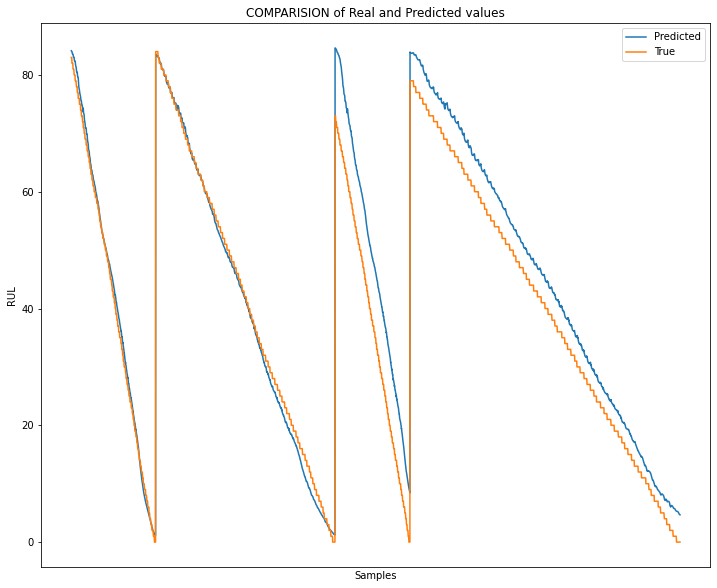

In [37]:
# %%time
MAE, scores2nd, seq_array_test, label_array_test, y_pred = lstm_test_evaluation(lstm_test_df, model_BiLSTM, sequence_length, sequence_cols)


In [ ]:
# saving the model with indication of training set
#model_BiLSTM.save("DS01_model_BiLSTM.h5")

In [ ]:
#model_BiLSTM = load_model('./DS08afull_10min_model_BiLSTM.h5')
#fp = open('../input/ds01-10min/DS01Train10min.obj', 'rb') 
#train_dfds = pickle.load(fp)
#fp = open('../input/ds02test10min/DS02Test10min.obj', 'rb') 
#test_dfds = pickle.load(fp)
#seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = lstm_data_preprocessing(train_dfds,test_dfds)
#MAE, scores2nd, seq_array_test, label_array_test, y_pred = lstm_test_evaluation(lstm_test_df, model_BiLSTM, sequence_length, sequence_cols)
#results = [label_array_test, y_pred]
#results
# Save a variable under the a specific name - change accordingly with sampling size
#with open('DS01full_10min_results.obj', 'wb') as fn: 
#     pickle.dump(results, fn)

#### Model LSTM

train_df shape >>  (8183, 26)
train_df >>     unit  cycle   Fc       alt      Mach       TRA        T2       T24  \
0   1.0    1.0  0.0  0.088623  0.363451  0.762491  0.928488  0.887124   
1   1.0    1.0  0.0  0.223178  0.526238  0.685535  0.841135  0.771572   
2   1.0    1.0  0.0  0.232637  0.567713  0.562477  0.849446  0.722503   
3   1.0    1.0  0.0  0.232639  0.568127  0.558758  0.849651  0.720986   
4   1.0    1.0  0.0  0.232587  0.568024  0.561252  0.849662  0.722132   

        P15        P2  ...       W25       W32       W48       W50     SmFan  \
0  0.863843  0.886842  ...  0.834272  0.834272  0.833245  0.833282  0.281314   
1  0.696737  0.741968  ...  0.665403  0.665403  0.664006  0.664069  0.419537   
2  0.668233  0.744040  ...  0.603385  0.603385  0.601406  0.601498  0.498628   
3  0.667481  0.744205  ...  0.601617  0.601617  0.599622  0.599716  0.500648   
4  0.668118  0.744240  ...  0.602888  0.602888  0.600903  0.600996  0.499413   

      SmLPC     SmHPC   RUL  label1  

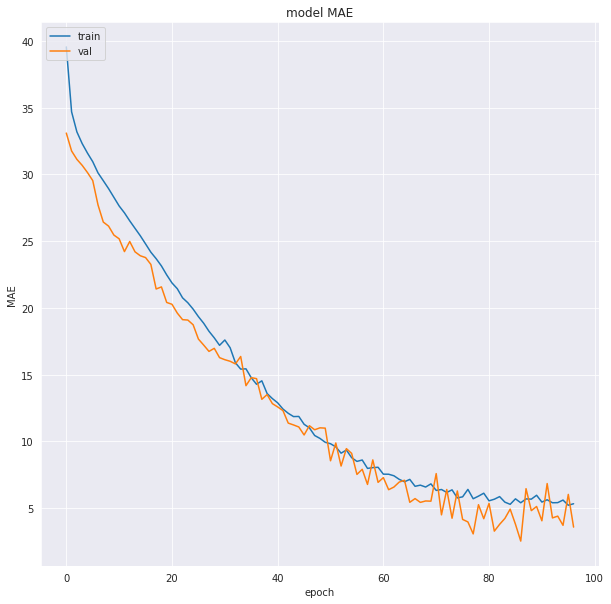

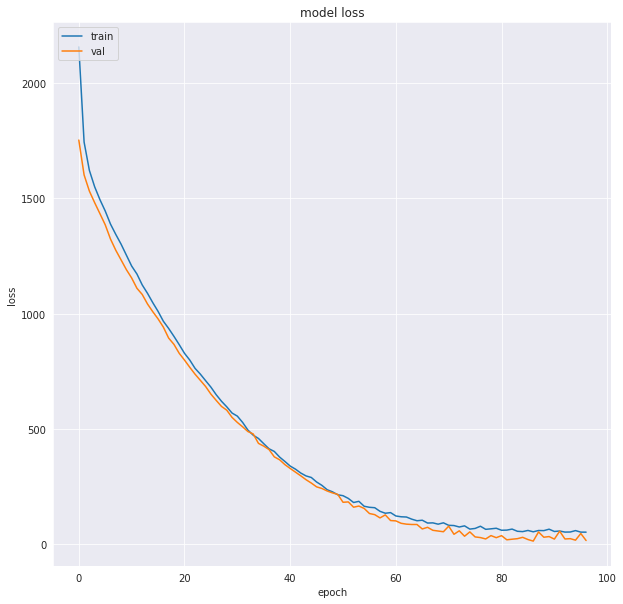

40/40 [==============================] - 0s 4ms/step - loss: 8.7785 - mae: 2.0401

MAE: 2.040055990219116
40/40 [==============================] - 1s 4ms/step
CPU times: user 23 s, sys: 1.29 s, total: 24.3 s
Wall time: 21 s


In [ ]:
%%time
# function calling - input is resampled raw Training data 
model_LSTM, history, lstm_test_df, seq_array_train, label_array_train, sequence_length, sequence_cols = train_models([train_df, test_df], "LSTM")

## Training results graphs : comparing training data and validation data - 80/20 split

lstm_val_evaluation_graphs(model_LSTM, history, seq_array_train, label_array_train)


 seq_array_test shape >>  (4362, 50, 23)

 label_array_test shape >>  (4362, 1)
137/137 [==============================] - 1s 4ms/step - loss: 25.4338 - mae: 3.8086

MAE: 3.8085763454437256

 Second Opinion metrics using the custom score function:
 NASA score 2394.84
 Mean absolute error 3.809999942779541
 Root mean squared error 5.042816703507652
 R2 score 0.95


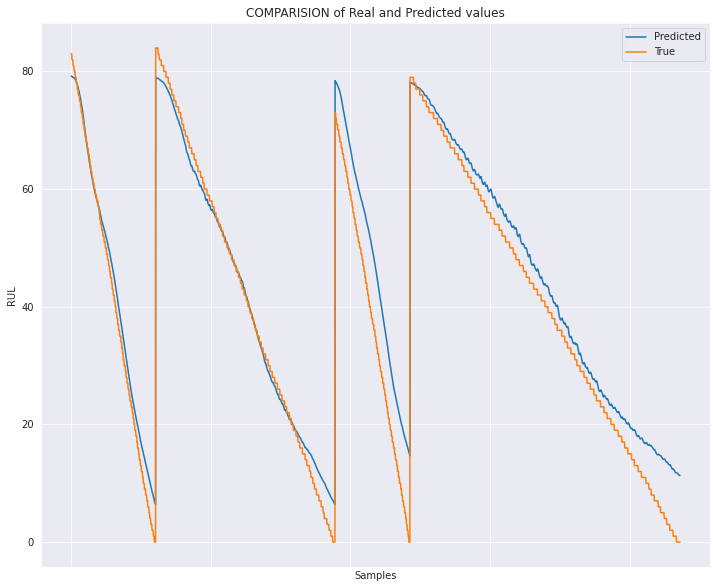

ValueError: too many values to unpack (expected 2)

In [ ]:
MAE, scores2nd = lstm_test_evaluation(lstm_test_df, model_LSTM, sequence_length, sequence_cols)

#### Model RF

 NASA score 5173.48
 Mean absolute error 7.03
 Root mean squared error 7.661592523751182
 R2 score 0.9


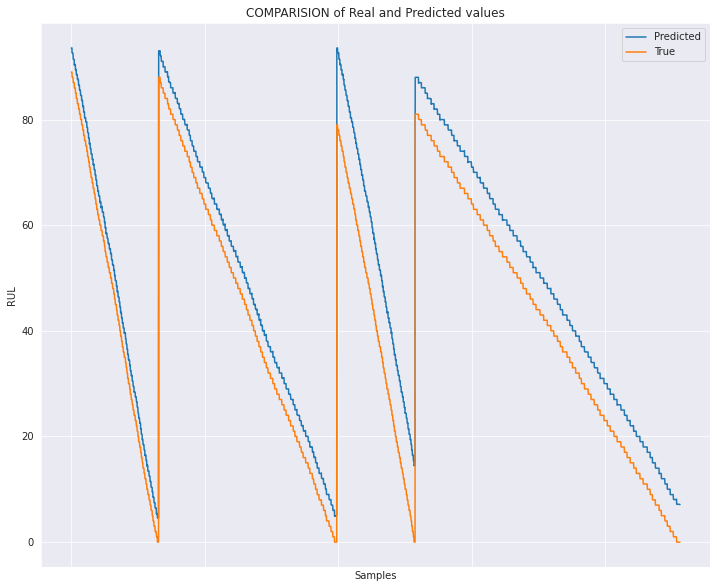

CPU times: user 6.35 s, sys: 110 ms, total: 6.46 s
Wall time: 3.68 s


In [ ]:
%%time
# train the model with actual training data - unusable features are removed inside the train_models function
model_RF = train_models(train_df)

# Visualize validation data
#print(train_df_val.head())

# Removing unusable columns AND target label RUL from the validation data
test_data = test_df.drop(columns=['hs','Mach','TRA','Nf','Wf','P2','P40','Ps30','T48','Nc','T50','P50','P24','P21','phi','SmFan','P45','W22','W25','W31','W32','W48','W50','RUL'])    
test_data_np = test_data.to_numpy()

# Making the prediction and visualising results
y_pred = model_RF.predict(test_data_np)
#print(y_pred.shape)
#print(y_pred)

# Real RUL from validation data set
y_true = test_df['RUL'].to_numpy()
#print(y_true.shape)

# calling score funtion to see the test metrics
RF_scorelst = score_func(y_true, y_pred)
# ploting true and predicted data
plot_result(y_true,y_pred)

#### Model XGBoost

In [ ]:
%%time
xgb = train_models(train_df,model="XGB")

y_xgb_pred = xgb.predict(test_data_np)

XGB_scorelst = score_func(y_true,y_xgb_pred)
plot_result(y_true,y_xgb_pred)

NameError: name 'train_models' is not defined